In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau, pearsonr
import sys
sys.path.append('..')
#from evaluation import get_fidelity_ltr,validity_completeness,  get_explain_ndcg, validity_completeness, get_infidelity, get_fidelity_ltr, get_dpff, summarize

from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from sklearn.metrics import ndcg_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re
from tabulate import tabulate

In [46]:
color_list = {
    'lpi': 'blue',
    'lirme': 'gold',
    'lime': 'darkorange',
    'shap': 'brown',
    'exs_top_k_rank': 'cyan', 
    'exs_top_k_binary': 'lightgreen', 
    'exs_score': 'magenta',
    'random_d': 'black',
    'pmi': 'turquoise',
    'greedy_score': 'blue',
    'rank_lime': 'green'
}

exp_names_figure = {
    'lime': 'LIME',
    'shap': 'SHAP',
    'lirme': 'LIRME',
    'exs_score': 'EXS (S)',
    'exs_top_k_binary': 'EXS (B)',
    'exs_top_k_rank': 'EXS (R)',
    'pmi': 'PMI',
    'greedy_score': 'Greedy Score',
    'lpi': 'LPI',
    'random_d': 'Random',
    'gt': 'GT (Baseline)',
    'ff': 'FF (Baseline)'
}
#subset_exps = ['pmi', 'greedy_score', 'rank_lime', 'lirme',
#           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random']
#subset_exps_alt = np.array(['PMI', 'GreedyScore', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)','LIME', 'SHAP', 'random'])

In [4]:
def evaluate(exps_file, test):
    eval = {'dpff': {}, 'fidelity_ltr': {}, 'validity': {}, 'completeness': {}, 'infidelity': {}, 'explain_ndcg': {}}
    exp_names = ['pmi', 'greedy_score', 'rank_lime', 'lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'random']
    measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity', 'explain_ndcg']
    
    for exp_name in exp_names:
        for m in measure_keys:
            eval[m][exp_name] = []
        
    for key in exps_file.keys():
        doc_values = test[key]
        for exp_name in exp_names:
            exp_val = exps_file[key][exp_name].flatten()
            #exp_val = min_max(exp_val)
            
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['validity'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'validity'))
            eval['completeness'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'completeness'))
            eval['infidelity'][exp_name].append(get_infidelity(exp_val, doc_values, ranker.predict, background))
            eval['explain_ndcg'][exp_name].append(get_explain_ndcg(exp_val, doc_values, ranker.predict))

            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['dpff'][exp_name].append(get_dpff(exp_val, doc_values, ranker))
    
    return eval

In [5]:
dataset_name = 'web10k'

In [6]:
ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(dataset_name))
exps = pickle.load( open( "../exps/{}_pointwise_exps_v3.p".format(dataset_name), "rb"))
q_exps = pickle.load( open( "../exps/{}_listwise_exps_v3.p".format(dataset_name), "rb" ) )
test_sample = pickle.load( open( "../data/{}_test_sample_v2.p".format(dataset_name), "rb" ) )
background_dict = pickle.load( open( "../data/{}_background_v3.p".format(dataset_name), "rb" ) )

In [7]:
res = {}
top_k_val = 0.2
for q in exps.keys():
    res[q] = {}
    for e in exps[q]:
        res_pred = ranker.predict(test_sample[q])
        top_k = int(top_k_val * len(res_pred))
        idx_res = res_pred.argsort()[-top_k:][::-1]
        res[q][e] = np.sum(np.array(exps[q][e])[idx_res], axis=0)

for q in res.keys():
    for e in res[q]:
        q_exps[q][e] = res[q][e]

queries = list(q_exps.keys())
exp_names = list(q_exps[queries[0]].keys())
ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(dataset_name))

In [8]:
background = []
for q in background_dict:
    background.extend(background_dict[q])
    
background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])

In [9]:
eval = evaluate(q_exps, test_sample)
pickle.dump(eval, open( f"./{dataset_name}_evaluate_summary_v3_top_20_percent.p", "wb" ) )

In [10]:
def load_and_summarize(file_name):
    eval_ = pickle.load( open( file_name, "rb" ) )
    summary_ = summarize(eval_)
    summary_df_ = pd.DataFrame(summary_)
    summary_df_ = summary_df_.reindex(columns=['dpff', 'fidelity_ltr', 'explain_ndcg', 'completeness', 'validity', 'infidelity'])
    summary_df_ = summary_df_.reindex(index=['pmi', 'greedy_score', 'rank_lime', 'lirme',
           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random'])
    summary_df_.columns = ['FF', 'Fidelity', 'Explain NDCG', 'Completeness', 'Validity', 'Infidelity']
    summary_df_.index = ['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP', 'Random']
    
    return summary_df_

In [25]:
summary_df = load_and_summarize(f"./{dataset_name}_evaluate_summary_v3_top_10_percent.p")#.round(2)

In [26]:
summary_df.T.style.highlight_max(axis=1)

,PMI,Greedy Score,RankLIME,LIRME,EXS (S),EXS (B),EXS (R),LIME,SHAP,Random
FF,0.553842,0.131761,0.048432,0.494435,0.506267,0.347686,0.004618,0.324924,0.520628,0.010925
Fidelity,-0.023475,-0.012394,0.875312,0.029207,0.042739,0.021795,-0.004978,0.056540,0.086556,0.002390
Explain NDCG,0.524575,0.512868,0.990000,0.560772,0.542847,0.568317,0.538741,0.554415,0.602316,0.529601
Completeness,41.783766,16.433747,17.729867,37.323817,37.921462,38.148481,14.214116,36.943672,38.627126,19.094860
Validity,0.057437,14.316500,10.931421,2.638737,2.669689,3.909288,10.686207,5.696988,2.751886,12.431892
Infidelity,0.029632,0.053240,-0.061601,-0.146660,-0.056843,-0.069948,0.047286,0.008337,-0.074095,0.040030


In [66]:
summary_df_2 = load_and_summarize(f"./{dataset_name}_evaluate_summary_v3_top_20_percent.p")#.round(2)

In [78]:
z = pd.concat([summary_df.T.iloc[:, 3:9], summary_df_2.T.iloc[:, 3:9]], axis=1)#.style.highlight_max(axis=1)

In [79]:
z

,LIRME,EXS (S),EXS (B),EXS (R),LIME,SHAP,LIRME,EXS (S),EXS (B),EXS (R),LIME,SHAP
FF,0.494435,0.506267,0.347686,0.004618,0.324924,0.520628,0.528036,0.534778,0.375608,0.003128,0.342363,0.533155
Fidelity,0.029207,0.042739,0.021795,-0.004978,0.056540,0.086556,0.023399,0.054432,0.031909,-0.035439,0.081996,0.109941
Explain NDCG,0.560772,0.542847,0.568317,0.538741,0.554415,0.602316,0.555697,0.549350,0.569744,0.529651,0.565788,0.592001
Completeness,37.323817,37.921462,38.148481,14.214116,36.943672,38.627126,37.579068,36.663133,37.976455,12.147655,33.334522,35.022444
Validity,2.638737,2.669689,3.909288,10.686207,5.696988,2.751886,2.727460,2.435543,3.687047,14.290488,5.319451,2.944977
Infidelity,-0.146660,-0.056843,-0.069948,0.047286,0.008337,-0.074095,-0.148687,-0.058264,-0.098215,0.028903,0.017505,-0.059820


In [82]:
z.columns = np.arange(0, 12)

In [83]:
z.round(2).style.highlight_min(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11
FF,0.490000,0.510000,0.350000,0.000000,0.320000,0.520000,0.530000,0.530000,0.380000,0.000000,0.340000,0.530000
Fidelity,0.030000,0.040000,0.020000,-0.000000,0.060000,0.090000,0.020000,0.050000,0.030000,-0.040000,0.080000,0.110000
Explain NDCG,0.560000,0.540000,0.570000,0.540000,0.550000,0.600000,0.560000,0.550000,0.570000,0.530000,0.570000,0.590000
Completeness,37.320000,37.920000,38.150000,14.210000,36.940000,38.630000,37.580000,36.660000,37.980000,12.150000,33.330000,35.020000
Validity,2.640000,2.670000,3.910000,10.690000,5.700000,2.750000,2.730000,2.440000,3.690000,14.290000,5.320000,2.940000
Infidelity,-0.150000,-0.060000,-0.070000,0.050000,0.010000,-0.070000,-0.150000,-0.060000,-0.100000,0.030000,0.020000,-0.060000


In [80]:
print(tabulate(z.round(2), tablefmt='latex_raw', headers=z.columns))

\begin{tabular}{lrrrrrrrrrrrr}
\hline
              &   LIRME &   EXS (S) &   EXS (B) &   EXS (R) &   LIME &   SHAP &   LIRME &   EXS (S) &   EXS (B) &   EXS (R) &   LIME &   SHAP \\
\hline
 FF           &    0.49 &      0.51 &      0.35 &      0    &   0.32 &   0.52 &    0.53 &      0.53 &      0.38 &      0    &   0.34 &   0.53 \\
 Fidelity     &    0.03 &      0.04 &      0.02 &     -0    &   0.06 &   0.09 &    0.02 &      0.05 &      0.03 &     -0.04 &   0.08 &   0.11 \\
 Explain NDCG &    0.56 &      0.54 &      0.57 &      0.54 &   0.55 &   0.6  &    0.56 &      0.55 &      0.57 &      0.53 &   0.57 &   0.59 \\
 Completeness &   37.32 &     37.92 &     38.15 &     14.21 &  36.94 &  38.63 &   37.58 &     36.66 &     37.98 &     12.15 &  33.33 &  35.02 \\
 Validity     &    2.64 &      2.67 &      3.91 &     10.69 &   5.7  &   2.75 &    2.73 &      2.44 &      3.69 &     14.29 &   5.32 &   2.94 \\
 Infidelity   &   -0.15 &     -0.06 &     -0.07 &      0.05 &   0.01 &  -0.07 &   -0.

In [3]:
def top_n_columns(row):
    size_row = row.shape[0]
    n = int(0.5 * size_row)
    return row.nlargest(n).index.tolist()

In [4]:
def get_feature_depth(model, node_depth=1):
    dframe_info = model.trees_to_dataframe()
    root_features_str = dframe_info[dframe_info['node_depth'] == node_depth]['split_feature'].values
    numeric_values = np.array([int(re.search(r'\d+', item).group()) for item in root_features_str if re.search(r'\d+', str(item))])
    
    return np.unique(numeric_values, return_counts=True)

def get_top_three(q_exps, e_name, top_k=0.1): 
    q_vals = []

    for q in q_exps.keys():
        q_vals.append(q_exps[q][e_name].flatten())
    temp = pd.DataFrame(np.array(q_vals))
    
    top_columns = temp.apply(top_n_columns, axis=1)
    f_top_columns = []
    for r in range(top_columns.shape[0]):
        f_top_columns.extend(top_columns.iloc[r])
    
    return np.unique(f_top_columns, return_counts=True)



def correlate_with_depth(q_exps, e_name, baseline): 
    q_vals = []

    for q in queries:
        #q_vals.append(q_exps[q][e_name].flatten())
        #q_vals.append(kendalltau(np.abs(q_exps[q][e_name].flatten()), baseline).statistic)
        q_vals.append(pearsonr(np.abs(q_exps[q][e_name].flatten()), baseline).statistic)
    #temp = pd.DataFrame(np.array(q_vals))
    
    return np.median(q_vals)

def get_depth_baseline(model, data):
    t = model.trees_to_dataframe()
    t = t[~t['split_feature'].isnull().values]
    feats = t['split_feature'].values
    node_depth = t['node_depth'].values
    cleaned_feats = []
    
    for f in feats: 
        cleaned_feats.append(int(f.split('Column_')[1]))
    cleaned_feats = np.array(cleaned_feats)
    median_rank = np.zeros(data.shape[1])
    
    for i in range(data.shape[1]):
        idx = np.argwhere(cleaned_feats == i).flatten()
        #median_rank[i] = np.median(node_depth[idx])
    median_rank[i] = np.median(node_depth[idx])
    median_rank = np.nan_to_num(median_rank)
    
    return median_rank

In [5]:
def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 11, weight = 'bold', color = '0.2')

    return ax

fig, ax = plt.subplots(1, 3, figsize=(11, 3), dpi=200, sharey=True)
dataset_names = ['mq2008', 'web10k', 'yahoo']

for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(dataset_name))
    exps = pickle.load( open( "../exps/{}_pointwise_exps_v3.p".format(dataset_name), "rb"))
    q_exps = pickle.load( open( "../exps/{}_listwise_exps_v3.p".format(dataset_name), "rb" ) )
    res = {}

    for q in exps.keys():
        res[q] = {}
        for p_exp in exps[q]:
            res[q][p_exp] = np.sum(np.array(exps[q][p_exp]), axis=0)
    for q in res.keys():
        for e in res[q]:
            q_exps[q][e] = res[q][e]
    
    test_sample = pickle.load( open( "../data/{}_test_sample_v2.p".format(dataset_name), "rb" ) )
    background_dict = pickle.load( open( "../data/{}_background_v3.p".format(dataset_name), "rb" ) )
    
    for j in range(len(subset_exps[:-1])):
        e_ = subset_exps[j]
        depth_result = []
        for k in range(1, 7):
            f, c = get_feature_depth(ranker, node_depth=k)
            a, b = get_top_three(q_exps, e_)
            common = len(np.intersect1d(a, f)) / len(f)
            depth_result.append(common)
        ax[i].plot(np.arange(1, 7), depth_result, label= exp_names_figure[e_], c=color_list[e_], linewidth=2)
    ax[i].set_xticks(np.arange(1, 7))
    ax[i].set_xticklabels(np.arange(1, 7))
    ax[i] = process_ax(ax[i])
    ax[i].set_xlabel('Feature Split Depth')
    
    ax[i].set_title(dataset_names[i].upper(), fontsize=12, fontweight='bold')

ax[2].legend(loc='upper right', prop = {'weight':'bold', 'size':7}, bbox_to_anchor=(1.4, 1))
ax[0].set_ylabel('In Top-50%', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./depth_overall_analysis.pdf')

### Normalization effect on ExplainNDCG

In [6]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

In [16]:
def evaluate(exps_file, test):
    eval = {'dpff': {}, 'fidelity_ltr': {}, 'validity': {}, 'completeness': {}, 'infidelity': {}, 'explain_ndcg': {}}
    exp_names = ['pmi', 'greedy_score', 'rank_lime', 'lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'random']
    measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity', 'explain_ndcg']
    
    for exp_name in exp_names:
        for m in measure_keys:
            eval[m][exp_name] = []
        
    for key in exps_file.keys():
        doc_values = test[key]
        for exp_name in exp_names:
            exp_val = exps_file[key][exp_name].flatten()
            #exp_val = exp_val/np.linalg.norm(exp_val)
            exp_val = min_max(exp_val)
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['validity'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'validity'))
            eval['completeness'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'completeness'))
            eval['infidelity'][exp_name].append(get_infidelity(exp_val, doc_values, ranker.predict, background))
            eval['explain_ndcg'][exp_name].append(get_explain_ndcg(exp_val, doc_values, ranker.predict))

            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['dpff'][exp_name].append(get_dpff(exp_val, doc_values, ranker))
    
    return eval

In [17]:
def load_and_summarize(eval_):
    #eval_ = pickle.load( open( file_name, "rb" ) )
    summary_ = summarize(eval_)
    summary_df_ = pd.DataFrame(summary_)
    summary_df_ = summary_df_.reindex(columns=['dpff', 'fidelity_ltr', 'explain_ndcg', 'completeness', 'validity', 'infidelity'])
    summary_df_ = summary_df_.reindex(index=['pmi', 'greedy_score', 'rank_lime', 'lirme',
           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random'])
    summary_df_.columns = ['FF', 'Fidelity', 'Explain NDCG', 'Completeness', 'Validity', 'Infidelity']
    summary_df_.index = ['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP', 'Random']
    
    return summary_df_

In [19]:
#eval = evaluate(q_exps, test_sample)

In [20]:
#load_and_summarize(eval).T.round(2).style.highlight_max(axis=1)

### Depth Analysis (v2)

In [7]:
def m_r(top_k_important, s_f):
    median_ranks = []
    for t_k in top_k_important:
        idx_split = np.argwhere(t_k == s_f).flatten()
        if len(idx_split) > 0: 
            median_ranks.append(np.median(n_d[idx_split]))
    return np.median(median_ranks)

In [8]:
def get_split_depth(ranker):
    dframe_info = ranker.trees_to_dataframe()
    root_features_str = dframe_info['split_feature'].values
    node_depths = dframe_info['node_depth'].values
    split_features = []
    
    for r in root_features_str:
        if r: 
            split_features.append(int(r.split('Column_')[1]))
        else: 
            split_features.append(np.nan)
    split_features = np.array(split_features)
    
    return split_features,node_depths

dataset_names = ['mq2008', 'web10k', 'yahoo']
cutoff = [20, 30, 40]
results = []
top_k_range_values = []

for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(dataset_name))
    exps = pickle.load( open( "../exps/{}_pointwise_exps_v3.p".format(dataset_name), "rb"))
    q_exps = pickle.load( open( "../exps/{}_listwise_exps_v3.p".format(dataset_name), "rb" ) )
    test_sample = pickle.load( open( "../data/{}_test_sample_v2.p".format(dataset_name), "rb" ) )
    background_dict = pickle.load( open( "../data/{}_background_v3.p".format(dataset_name), "rb" ) )
    
    res = {}
    
    for q in exps.keys():
        res[q] = {}
        for p_exp in exps[q]:
            res[q][p_exp] = np.sum(np.array(exps[q][p_exp]), axis=0)
    for q in res.keys():
        for e in res[q]:
            q_exps[q][e] = res[q][e]
    
    queries = list(q_exps.keys())
    exp_names = list(q_exps[queries[0]].keys())
    ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(dataset_name))

    background = []
    
    for q in background_dict:
        background.extend(background_dict[q])
        
    background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])
    
    top_k_range = np.arange(int(0.1 * background.shape[1]), int(0.9 * background.shape[1]), cutoff[i])
    top_k_range_values.append(top_k_range)
    
    result = np.zeros((len(top_k_range), len(subset_exps) - 1))
    
    for k in range(len(top_k_range)):
        top_k = top_k_range[k] 
        temp = m_r(q_exps, ranker, top_k)
        for j in range(len(subset_exps) - 1):
            result[k, j] = np.median(temp[subset_exps[j]])
    results.append(result)

In [29]:
subset_exp = ['lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank',  'lpi']

In [30]:
dataset_names = ['mq2008', 'web10k', 'yahoo']
cutoff = [5, 30, 40]
result = {}
top_k_range_values = []

for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(dataset_name))
    exps = pickle.load( open( "../exps/{}_pointwise_exps_v3.p".format(dataset_name), "rb"))
    lpi_exps = pickle.load( open( "../exps/{}_pointwise_exps_v4.p".format(dataset_name), "rb"))

    test_sample = pickle.load( open( "../data/{}_test_sample_v2.p".format(dataset_name), "rb" ) )
    background_dict = pickle.load( open( "../data/{}_background_v3.p".format(dataset_name), "rb" ) )
    
    for q in exps.keys():
        exps[q]['lpi'] = np.array(lpi_exps[q]['lpi'])

    queries = list(exps.keys())
    exp_names = list(exps[queries[0]].keys())

    background = []
    
    for q in background_dict:
        background.extend(background_dict[q])
        
    background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])
    
    top_k_range = np.arange(int(0.1 * background.shape[1]), int(0.9 * background.shape[1]), cutoff[i])
    top_k_range_values.append(top_k_range)

    s_f, n_d = get_split_depth(ranker)

    result[dataset_name] = {}
    for e in subset_exp:
        result[dataset_name][e] = []
        for j in range(len(top_k_range)):
            tmp_ = []
            for q in exps.keys():
                for k in range(len(exps[q][e])):
                    top_k = top_k_range[j]
                    top_k_important = np.abs(np.array(exps[q][e][k]).flatten()).argsort()[-top_k:][::-1]
                    tmp_.append(m_r(top_k_important, s_f))
            result[dataset_name][e].append(np.median(tmp_))
pickle.dump( result, open( "./effect_of_rank.p", "wb" ) )

In [64]:
result[dataset_name].keys()

dict_keys(['lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lpi'])

In [69]:
subset_exps = ['lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank','lpi']

In [70]:
subset_exps

['lime',
 'shap',
 'lirme',
 'exs_score',
 'exs_top_k_binary',
 'exs_top_k_rank',
 'lpi']

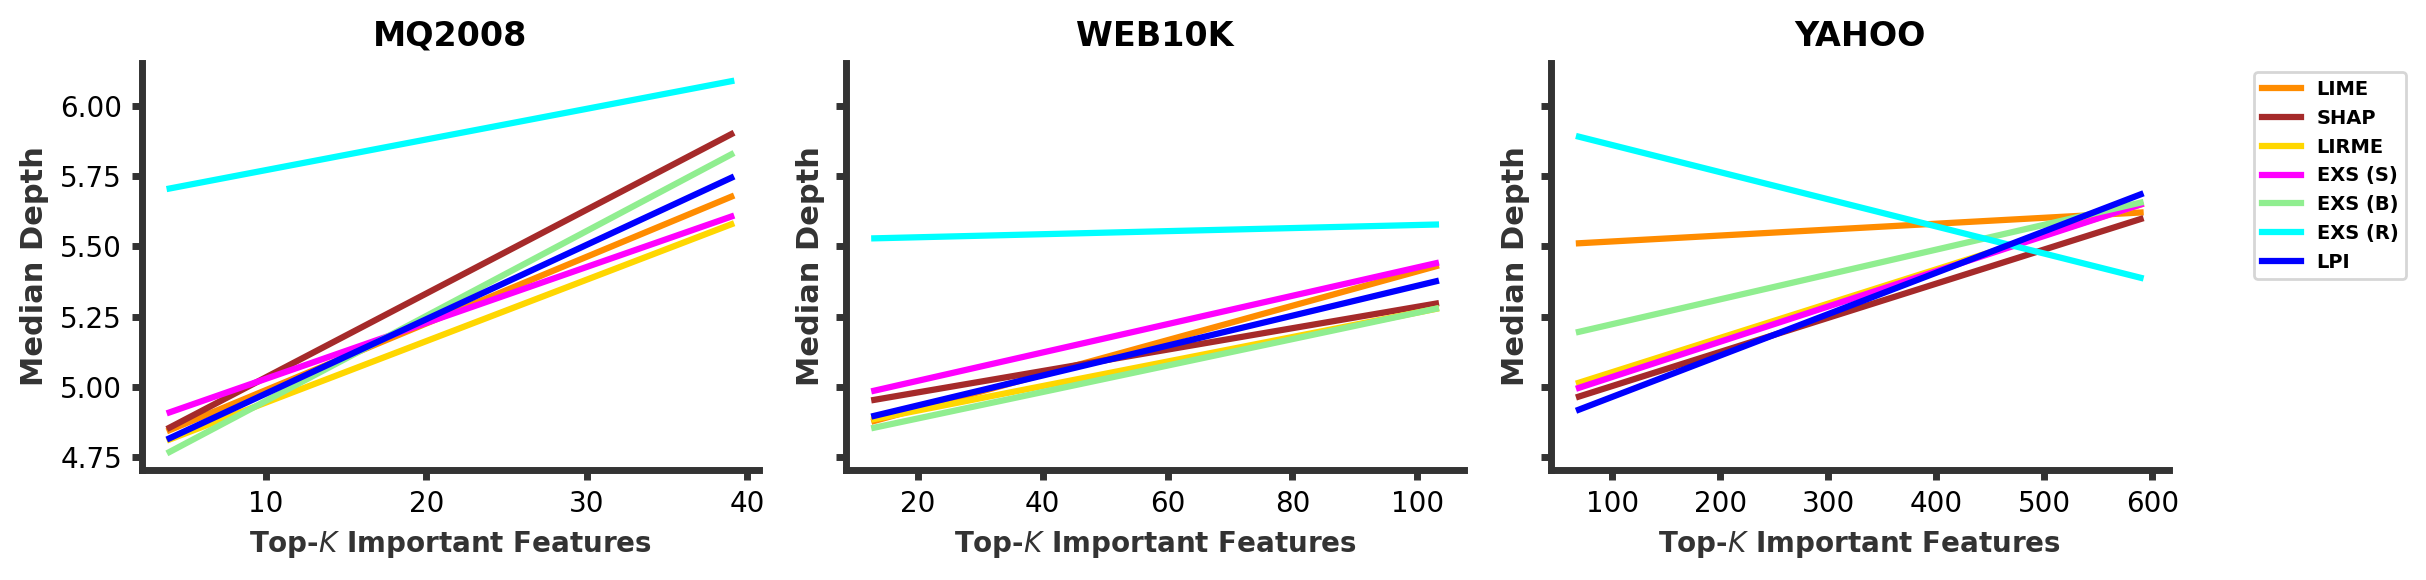

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200, sharey=True)

for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    for j in range(len(subset_exps)):
        sns.regplot(x=top_k_range_values[i], y=result[dataset_name][subset_exps[j]]  + np.random.normal(scale=0.1, size=len(top_k_range_values[i])), 
                    label=exp_names_figure[subset_exps[j]], ci=0, scatter=False, ax=ax[i], 
                    color=color_list[subset_exps[j]],scatter_kws={'alpha':0.5})

    ax[i].set_title(dataset_names[i].upper(), fontsize=12, fontweight='bold')
    ax[i] = process_ax(ax[i])
    ax[i].set_xlabel(r'Top-$K$ Important Features', fontsize=10)
    ax[i].set_ylabel(r'Median Depth')
ax[2].legend(loc='upper right', prop = {'weight':'bold', 'size':7}, bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.savefig('./depth_explanations.pdf')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3), dpi=200, sharey=True)
dataset_names = ['mq2008', 'web10k', 'yahoo']

for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(dataset_name))
    exps = pickle.load( open( "../exps/{}_pointwise_exps_v3.p".format(dataset_name), "rb"))
    q_exps = pickle.load( open( "../exps/{}_listwise_exps_v3.p".format(dataset_name), "rb" ) )
    res = {}

    for q in exps.keys():
        res[q] = {}
        for p_exp in exps[q]:
            res[q][p_exp] = np.sum(np.array(exps[q][p_exp]), axis=0)
    for q in res.keys():
        for e in res[q]:
            q_exps[q][e] = res[q][e]
    
    test_sample = pickle.load( open( "../data/{}_test_sample_v2.p".format(dataset_name), "rb" ) )
    background_dict = pickle.load( open( "../data/{}_background_v3.p".format(dataset_name), "rb" ) )
    
    for j in range(len(subset_exps[:-1])):
        e_ = subset_exps[j]
        depth_result = []
        for k in range(1, 7):
            a, b = get_non_zero(q_exps, e_)
            f, c = get_feature_depth(ranker, node_depth=k)
            common = len(np.intersect1d(a, f)) / len(f)
            depth_result.append(common)
        ax[i].plot(np.arange(1, 7), depth_result, label= exp_names_figure[e_], c=color_list[e_], linewidth=2)
    ax[i].set_xticks(np.arange(1, 7))
    ax[i].set_xticklabels(np.arange(1, 7))
    ax[i] = process_ax(ax[i])
    ax[i].set_xlabel('Feature Split Depth')
    
    ax[i].set_title(dataset_names[i].upper(), fontsize=12, fontweight='bold')

ax[2].legend(loc='upper right', prop = {'weight':'bold', 'size':7}, bbox_to_anchor=(1.4, 1))
ax[0].set_ylabel('In Top-50%', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./depth_overall_analysis.pdf')